# Projeto 9 Código e Relatório - MAC0318
## Felipe Felix - 8941092
## Lucas Helfstein - 8802426

# Definições de métodos utilizados neste notebook

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data_path = 'data/num/'
full_path = os.getcwd() + '/' + data_path

filenames = []

for filename in os.listdir(full_path):
    filenames.append(data_path + filename)
    
def erro(df):
    # Calcula erro
    dif = df['read'] - df['expected']
    return dif

def erro_quadratico(df):
    # Calcula erro quadrático
    dif = df['read'] - df['expected']
    return dif**2

def ignore_255(df):
    # Ignora medições maiores que 255
    return df[df['read'] <= 255]

def erros_pequenos(df):
    # Considera apenas erros pequenos
    return df[(df['read'] - df['expected']) <10]

def infos_limpas(nome_do_arquivo):
    # Retorna um dataframe limpo, sem considerar outliers
    df = pd.read_csv(nome_do_arquivo)
    df = ignore_255(df)
    df = erros_pequenos(df)
    return df

def infos_sujas(nome_do_arquivo):
    # Retorna um dataframe com outliers
    df = pd.read_csv(nome_do_arquivo)
    return df

def normal_hist_df(df):
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    data = df

    # Fit a normal distribution to the data:
    mu, std = norm.fit(df)

    # Plot the histogram.
    plt.hist(df, normed=True, alpha=0.6, color='g', width=0.95)

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()
    
def plot_euclidean(filename):
    # fazer essa daqui usando kwargs pra dataframes
    if filename:
        x_ax = []
        y_ax = []
        df = infos_sujas(filename)
        points = polarToEuclidian(df)
        for point in all_points:
            x_ax.append(point[0])
            y_ax.append(point[1])
        plt.scatter(x_ax, y_ax)

## Criando um dicionário dos valores "read" que são repetidos

Assim podemos usar esses dados para criar distribuições normais individuais para cada valor de read, obtendo suas variâncias.

In [2]:
df = infos_sujas('data/num/segunda.txt')

duplicates = list(set(df.read.values))
values = []

for duplicate in duplicates:
    df_duplicated = df[df.read == duplicate]
    values.append(df_duplicated)
    
data = {x:y for x,y in zip(duplicates, values)}

# Histogramas comparando exclusão de outliers

O gráfico limpo mostra o erro quadrático para erros menores que 10 e pontos lidos menores que 255.
O gráfico sujo mostra o erro quadrático para todos os dados coletados, sem limpeza.

Podemos notar que sem fazer uma limpeza dos dados, não é possível chegar em valores razoáveis.

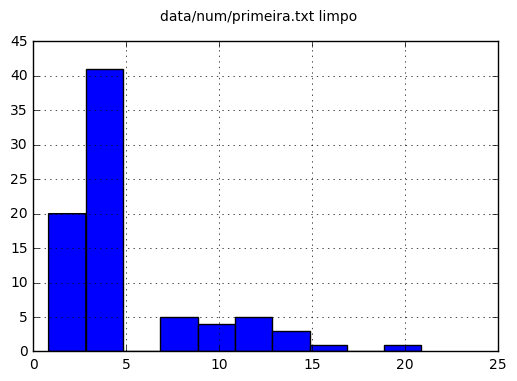

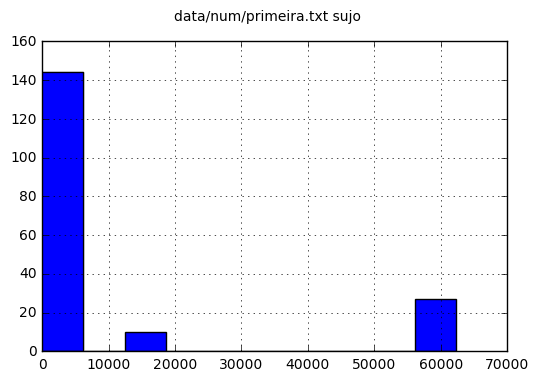

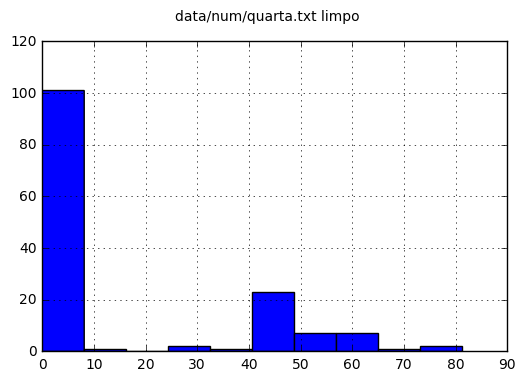

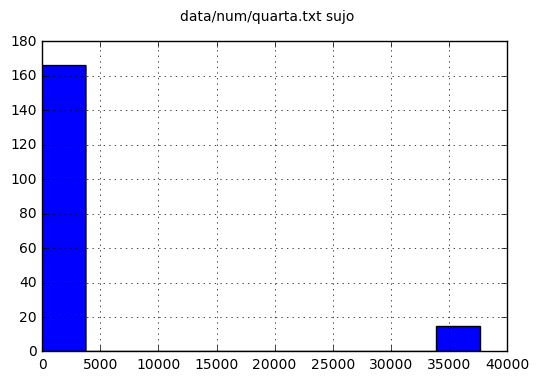

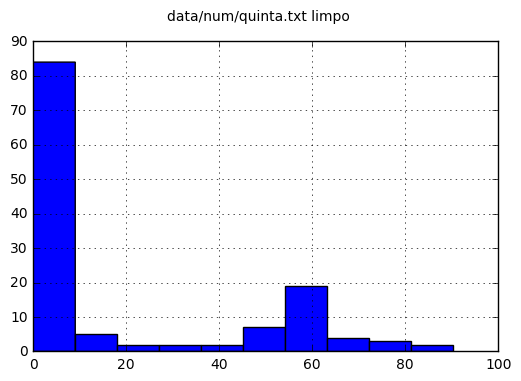

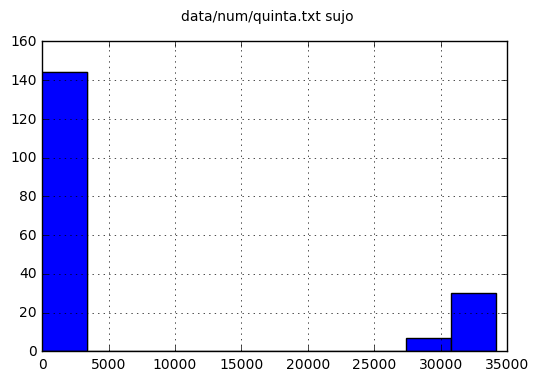

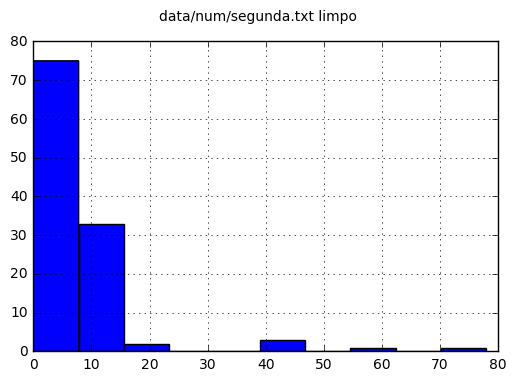

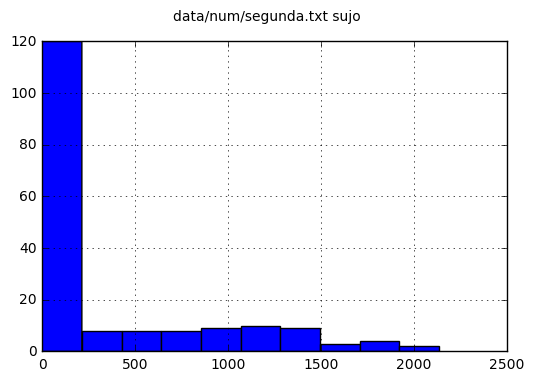

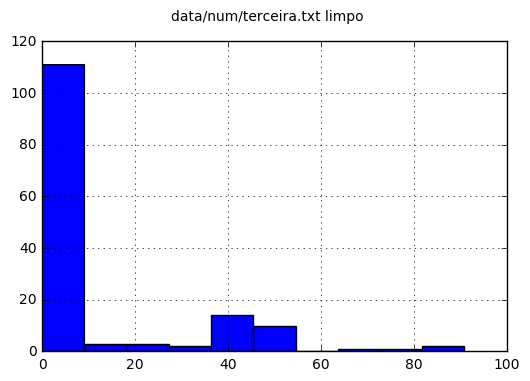

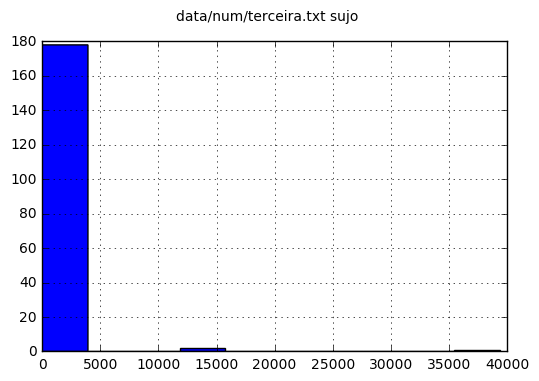

In [3]:
import pylab as pl

for filename in filenames:
    df_limpo = infos_limpas(filename)
    df_sujo = infos_sujas(filename)
    x_limpo = erro_quadratico(df_limpo)
    x_sujo = erro_quadratico(df_sujo)
    plt.figure();
    pl.suptitle(filename + ' limpo')
    x_limpo.hist()
    
    plt.figure();
    pl.suptitle(filename + ' sujo')
    x_sujo.hist()

## Aqui temos o histograma de todos os erros (não quadráticos) de dados filtrados

Podemos ver uma distribuição normal em torno do zero. 

In [4]:
all_data = erro(erros_pequenos(ignore_255(df_total)))
plt.figure();
pl.suptitle('Todos os dados')
all_data.hist()


NameError: name 'df_total' is not defined

## Aqui podemos ver a normal de todos os dados coletados, com uma supervisão dos dados

Baseado neste gráfico, tomaremos para nossa distribuição normal do modelo de incerteza um desvio padrão de 3.5.

In [ ]:
df_total = []
for filename in filenames:
    df_total.append(infos_limpas(filename))
df_total = pd.concat(df_total)
df_total = erro(df_total)
normal_hist_df(df_total)

## Aqui podemos ver a normal de todos os dados coletados, sem supervisão dos dados

ValueError: could not convert string to float: 'k'

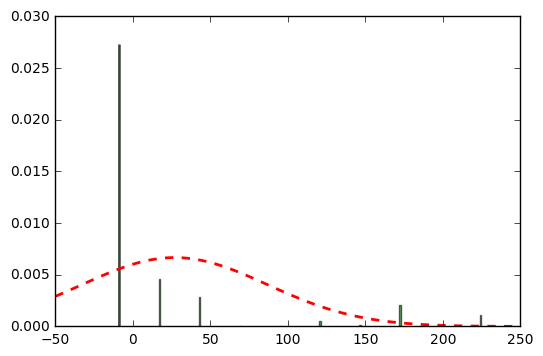

In [5]:
df_total = []
for filename in filenames:
    df_total.append(infos_sujas(filename))
df_total = pd.concat(df_total)
df_total = erro(df_total)
normal_hist_df(df_total)

# Modelo de incerteza

Seguindo os conceitos passados no slide.

In [7]:
import math
    
class modelo_incerteza:
    
    # criar modelo baseado em um df
    def __init__(self, df):
        self.df = df
        self.sigma = math.sqrt(3)
        self.z_min = 0
        self.z_max = 255
        self.N = len(df)
        self.read_expected = list(zip(df_total['read'], df_total['expected']))

        # primeiros coeficientes coeficientes da combinação convexa
        self.w_objeto = 0.8
        self.w_outros = 0.10
        self.w_limite = 0.10

    def p_objeto(self, z, z_exp):
        # prob(z) dist. normal centrada no expected
        x = (-1.0) * ((z - z_exp)**2) / 2 * ((self.sigma)**2)
        return math.exp(x)/(1/((self.sigma**2)*math.sqrt(2*math.pi)))
        
    def p_objeto_s(self, z, z_exp, sigma):
        # prob(z) dist. normal centrada no expected com um sigma diferente
        x = (-1.0) * ((z - z_exp)**2) / 2 * ((sigma))
        return math.exp(x)/(1/((sigma)*math.sqrt(2*math.pi)))
    
    def p_outros(self, z):
        # uma representação de distribuição uniforme
        if z >= self.z_min and z <= self.z_max:
            return ((1) / (self.z_max - self.z_min))
        else:
            return 0

    def p_limites(self, z):
        if z == self.z_max:
            return 1
        else:
            return 0
        
    def prob(self, z, z_exp):
        return self.w_objeto * self.p_objeto(z, z_exp) + self.w_outros * self.p_outros(z) + self.w_limite * self.p_limites(z)
    
    def expectation_maximization(self):
        w_obj = self.w_objeto
        w_out = self.w_outros
        w_lim = self.w_limite
        w_sigma  = self.sigma
        sig2 = self.sigma**2
        read_expected = self.read_expected
        converged = False
        p_antigo = 0
        thres = 0.0001
        
        while not converged:       
            sig_num = 0
            sig_den = 0
            p = 0
            for measure in read_expected:
                read     = measure[0]
                expected = measure[1]
                
                p_obj = self.p_objeto_s(read, expected, sig2)
                p_out = self.p_outros(read)
                p_lim = self.p_limites(read)

                n = 1/(p_obj + p_out + p_lim)
                
                e_objeto  = n*p_obj
                e_outros  = n*p_out
                e_limites = n*p_lim
                w_obj += e_objeto
                w_out += e_outros
                w_lim += e_limites
                
                sig_num += e_objeto*((read - expected)**2)
                
                sig_den += e_objeto
                
                p += math.log(w_obj*p_obj + w_out*p_out + w_lim*p_lim)

            N = self.N
            w_obj = w_obj/N
            w_out = w_out/N
            w_lim = w_lim/N
            sig2 = sig_num/sig_den
            
            if abs(p - p_antigo) < thres:
                converged = True
                break

            p_antigo = p
            w_obj = 0
            w_out = 0
            w_lim = 0
            
        self.w_objeto = w_obj
        self.w_outros = w_out
        self.w_limite = w_lim
        self.sigma    = math.sqrt(sig2)
    
    def print_coef(self):
        print("w_objeto: {}\nw_outros: {}\nw_limite: {}\nsigma: {}\nvariance: {}\n".format(self.w_objeto, self.w_outros, self.w_limite, self.sigma, self.sigma**2))
    

# Estimando coeficientes para o modelo de incerteza

Abaixo instanciamos nossa classe do modelo de incerteza e rodamos o algoritmo de expectation maximization para obter os coeficientes.

In [9]:
df_total = []
for filename in filenames:
    df_total.append(infos_sujas(filename))
df_total = pd.concat(df_total)

model = modelo_incerteza(df_total)
model.expectation_maximization()
model.print_coef()

w_objeto: 0.47249936278566823
w_outros: 0.4394481510264867
w_limite: 0.08805248618784531
sigma: 1.3925922220432132
variance: 1.939313096895254



# Distribuições separadas

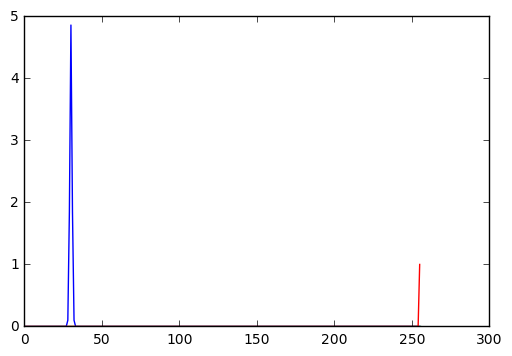

In [27]:
p_obj = [model.p_objeto(i, 30) for i in range(256)]
p_out = [model.p_outros(i) for i in range(256)]
p_lim = [model.p_limites(i) for i in range(256)]
plt.plot(p_obj)
plt.plot(p_out) # o p_out possui valores próximos a 0
plt.plot(p_lim)

# Distribuição conjunta

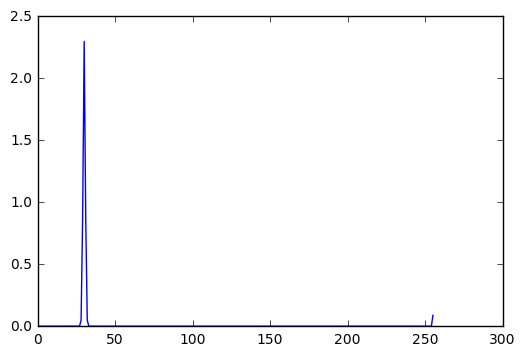

In [28]:
p = [model.prob(i, 30) for i in range(256)]
plt.plot(p)

# Utilização do modelo de incerteza

O modelo de incerteza pode ser está utilizado em futuras medições do sonar. 

Para considerar se um ponto é relevante, basta verificar se a probabilidade de aquele ponto e ver se ela está dentro de um intervalo aceitável.

O modelo pode ser aperfeiçoado se usarmos variâncias entre faixas de pontos, ao invés de apenas uma distribuição normal.

Podemos também alimentar com mais dados coletados de maneira inteligente para aperfeiçoar as distribuições.